In [1]:
import torch
import sys
import torch
import os.path as osp
import tqdm
import sys
import numpy as np
sys.path.append('/eos/home-g/gkrzmanc/mlpf_data/')
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
import dgl
from sklearn.decomposition import PCA


In [2]:
class Args:
    def __init__(self):
        self.data_train = ["/eos/user/g/gkrzmanc/ClicDet_v1_25_07_2023_full.root"]
        self.data_val = ['/eos/user/g/gkrzmanc/ClicDet_v1_25_07_2023_full.root']
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_data/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False
args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')

In [31]:
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                                   extra_selection=args.extra_selection,
                                   remake_weights= True,
                                   load_range_and_fraction=(train_range, args.data_fraction),
                                   file_fraction=args.file_fraction,
                                   fetch_by_files=args.fetch_by_files,
                                   fetch_step=args.fetch_step,
                                   infinity_mode= False,
                                   in_memory=args.in_memory,
                                   async_load = False,
                                   name='train', dataset_cap=5)

In [32]:
iterator = iter(train_data)

!!! Dataset_cap flag set, disabling shuffling
=== Restarting DataIter train, seed=None ===


In [33]:

g, y = next(iterator)

In [34]:
print(np.unique(g.ndata['particle_number']))
print(y.shape)

[1. 2.]
torch.Size([2, 7])


In [53]:
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=5, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)

In [54]:
iterator = iter(train_loader)
g, y = next(iterator)


!!! Dataset_cap flag set, disabling shuffling
=== Restarting DataIter train, seed=None ===


In [55]:
from src.models.wrapper.example_gravnet_model import GraphTransformerNetWrapper
model = GraphTransformerNetWrapper('cpu', output_dim=30, n_postgn_dense_blocks=4)


new_model = "/eos/home-g/gkrzmanc/mlpf_data/25_07_2023_norm_knn_FULL_10k/_epoch-68_state.pt"  # normalized KNN model


old_model = "/eos/user/g/gkrzmanc/mlpf_data/25_07_2023/_epoch-48_state.pt"  # old model

new_model_2 = "/eos/home-g/gkrzmanc/mlpf_data/25_07_2023_norm_knn_FULL_10k_32Dim_clustering/_epoch-20_state.pt"  # 32 dim clustering
new_model_3 = "/eos/home-g/gkrzmanc/mlpf_data/25_07_2023_norm_knn_FULL_10k_1BLOCK_1/_epoch-6_state.pt"  # only 1 block of post-gravnet dense

new_model_4 = "/eos/home-g/gkrzmanc/mlpf_data/k_zero_debug_260723_1/_epoch-3_state.pt"

new_model_5 = "/eos/home-g/gkrzmanc/mlpf_data/overfit_test_debug_260723_1/_epoch-12_state.pt"   # overfitting with 10 events
overfit_model = "/eos/home-g/gkrzmanc/mlpf_data/overfit-1-event/_epoch-244_state.pt"

new_model_hits_only = "/eos/home-g/gkrzmanc/mlpf_data/hits_only_model_260723/_epoch-20_state.pt"
model.load_state_dict(torch.load(overfit_model, map_location='cpu'))

<All keys matched successfully>

In [56]:
pred = model(g)

In [57]:

print(pred.shape)
_, S = pred.shape
xj = pred[:, 0:2]  # 0, 1 : cluster space coords
if xj.shape[1] > 2:
    print("doing PCA")
    pca = PCA(n_components=2)
    xj = pca.fit_transform(xj.detach().cpu().numpy())
    bj = torch.sigmoid(torch.reshape(pred[:, 32], [-1, 1]))
else:
    xj = xj.detach().numpy()
    bj = torch.sigmoid(torch.reshape(pred[:, 2], [-1, 1]))
#
all_embeddings = False
if all_embeddings:
    xj = pred
    pca = PCA(n_components=2)
    xj = pca.fit_transform(xj.detach().cpu().numpy())



torch.Size([2986, 30])


In [58]:
q = (bj.arctanh() ** 2 + 0.1).flatten()

[805, 120, 544, 519, 998]
[805, 120, 544, 519, 998]
[805, 120, 544, 519, 998]
[805, 120, 544, 519, 998]


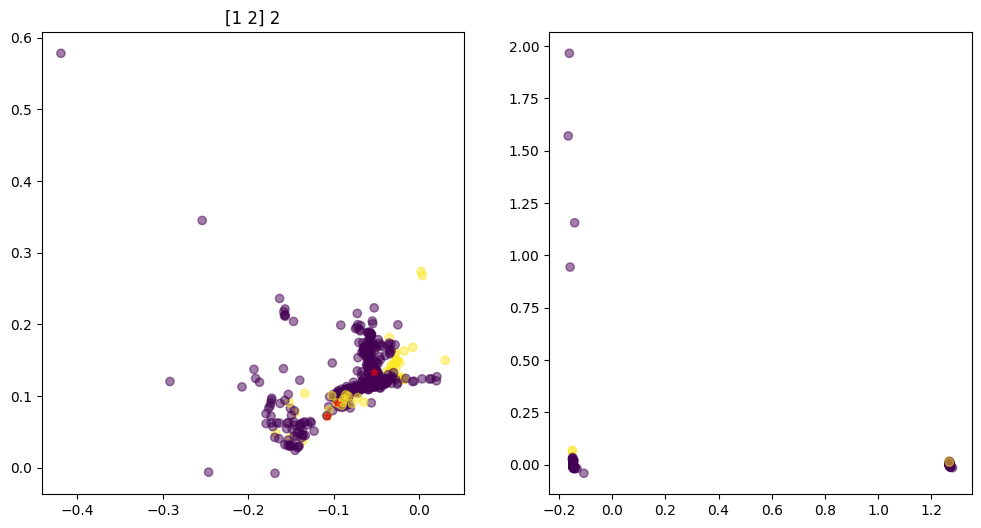

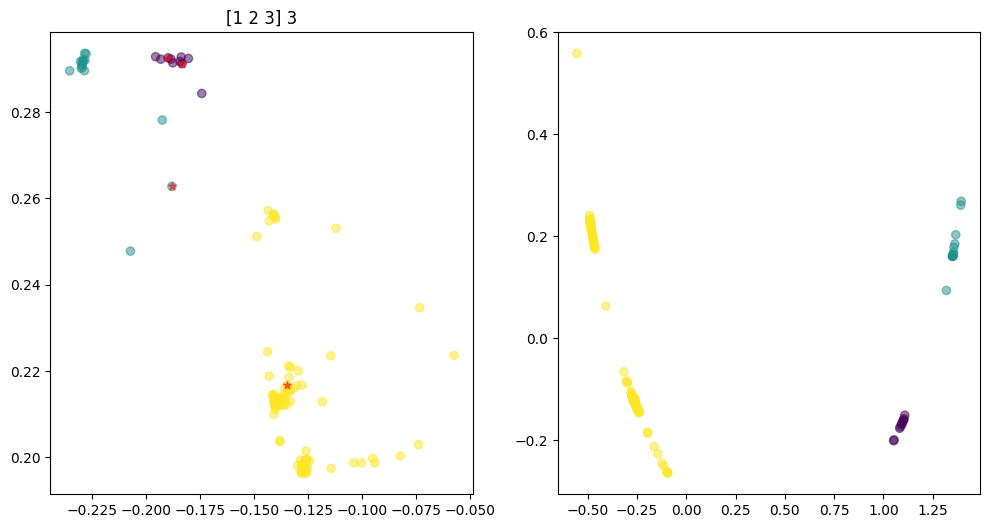

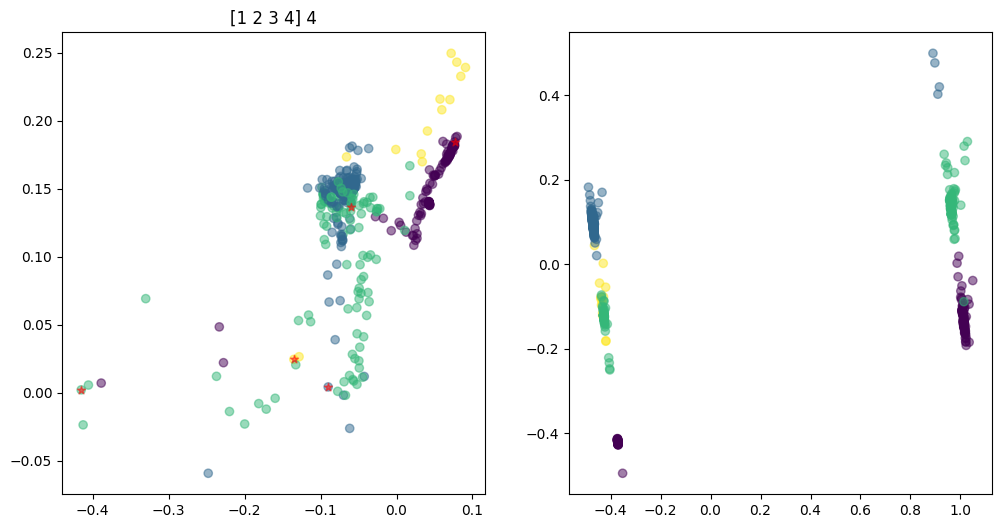

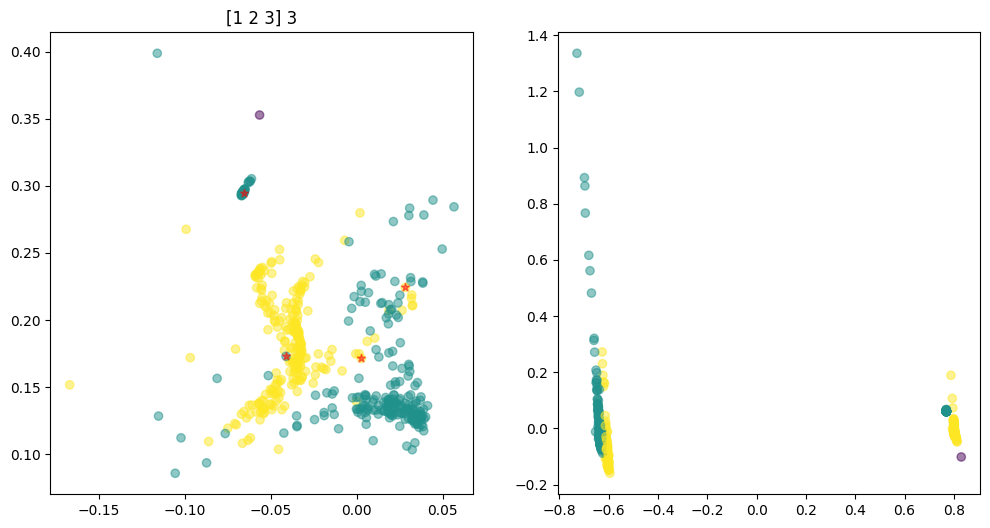

In [59]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_scatter import scatter_max, scatter_add, scatter_mean
graph_list = dgl.unbatch(g)
#graph_list = list(train_loader)
#graph_list = [x[0] for x in graph_list]

node_counter = 0
how_many_to_plot = 4

for i in range(how_many_to_plot):
    graph_eval = graph_list[i]
    print([g.num_nodes() for g in graph_list])
    non = graph_eval.number_of_nodes()
    assert non == graph_eval.ndata['h'].shape[0]
    particle_number = graph_eval.ndata['particle_number']-1
    #if particle_number.max() > 1:
    #    print("skipping one, only plotting events with 2 particles")
    #    continue
    #print(particle_number)
    q_graph = q[node_counter:node_counter+non]
    hit_type = torch.argmax(graph_eval.ndata['hit_type'],dim=1).view(-1)
    PCA_2d_node_feats = PCA(n_components=2).fit_transform(graph_eval.ndata['h'].detach().numpy())
    part_num = graph_eval.ndata['particle_number'].view(-1).to(torch.long)
    q_alpha, index_alpha = scatter_max(q_graph.view(-1), part_num)
    xj_graph = xj[node_counter:node_counter+non, :]

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    clr = graph_eval.ndata["particle_number"]
    axs[0].set_title(str(np.unique(part_num)) + " " + str(len(np.unique(part_num))))
    axs[0].scatter(xj_graph[:,0], xj_graph[:, 1], c=clr.tolist(), alpha=0.5)
    axs[1].scatter(PCA_2d_node_feats[:,0], PCA_2d_node_feats[:,1], c=clr.tolist(), alpha=0.5)
    axs[0].scatter(xj_graph[index_alpha-1][:, 0],xj_graph[index_alpha-1][:, 1], marker='*', c ="r", alpha=0.5)
    pos = graph_eval.ndata['pos_hits_norm']
    node_counter += non


In [60]:
graph_list[0]

Graph(num_nodes=805, num_edges=5635,
      ndata_schemes={'h': Scheme(shape=(9,), dtype=torch.float32), 'pos_hits': Scheme(shape=(3,), dtype=torch.float32), 'pos_hits_norm': Scheme(shape=(3,), dtype=torch.float32), 'hit_type': Scheme(shape=(4,), dtype=torch.int64), 'p_hits': Scheme(shape=(1,), dtype=torch.float32), 'e_hits': Scheme(shape=(1,), dtype=torch.float32), 'particle_number': Scheme(shape=(), dtype=torch.float32), 'particle_number_nomap': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})

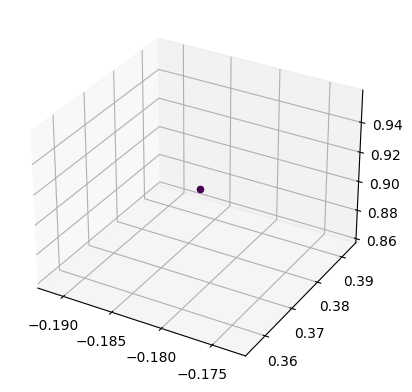

In [61]:
i = 1
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
particle_id = graph_eval.ndata['particle_number'].view(-1)
ax.scatter(pos[:,0][particle_id==i], pos[:,1][particle_id==i], pos[:,2][particle_id==i],marker='o', c = hit_type[particle_id==i], alpha=1)

In [62]:
np.unique(particle_id)

array([1., 2., 3.], dtype=float32)